# Deep Learning Final Project Notebook - Developing the CNN model on Raw images

By:

Adel del Valle - ad7082

Jayanth Rao - jr6594

Joshua Alfred Jayapal - jj3811

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


## Loading the Dataset

loading the whole dataset as a single folder caused IO errors on Colab, and so we partitioned and compiled the dataset into 4 zip files.

In [2]:
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-001.zip -d /content/
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-002.zip -d /content/
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-003.zip -d /content/
!unzip /content/drive/MyDrive/DL_DeepFake_Dataset-004.zip -d /content/


Streaming output truncated to the last 5000 lines.
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14110.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14092.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14086.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14081.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14072.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14135.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14071.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14078.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14057.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14068.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14125.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/seed14062.png  
  inflating: /content/DL_DeepFake_Dataset/data/fake_faces/see

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data Preparation and Preprocessing


In [4]:
class FaceDataset(Dataset):
    def __init__(self, real_dir, fake_dir, transform=None):

        self.real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        self.fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)
                            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]


        min_length = min(len(self.real_images), len(self.fake_images))
        self.real_images = self.real_images[:min_length]
        self.fake_images = self.fake_images[:min_length]


        self.images = self.real_images + self.fake_images
        self.labels = [0] * min_length + [1] * min_length


        indices = np.arange(len(self.images))
        np.random.seed(42)
        np.random.shuffle(indices)

        self.images = [self.images[i] for i in indices]
        self.labels = [self.labels[i] for i in indices]

        self.transform = transform or transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

def create_dataloaders(real_dir, fake_dir, batch_size=32, num_workers=4):


    full_dataset = FaceDataset(real_dir, fake_dir)


    total_size = len(full_dataset)
    train_size = int(0.7 * total_size) # 70% training
    val_size = int(0.2 * total_size) # 20% validation
    test_size = total_size - train_size - val_size # 10% testing


    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )


    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )


    def check_class_balance(loader, split_name):
        class_counts = {0: 0, 1: 0}
        for _, labels in loader:
            for label in labels:
                class_counts[label.item()] += 1
        print(f"{split_name} set class balance:")
        print(f"Real faces (0): {class_counts[0]}")
        print(f"Fake faces (1): {class_counts[1]}")

    check_class_balance(train_loader, "Train")
    check_class_balance(val_loader, "Validation")
    check_class_balance(test_loader, "Test")

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = create_dataloaders(
    real_dir = '/content/DL_DeepFake_Dataset/data/real_faces',
    fake_dir = '/content/DL_DeepFake_Dataset/data/fake_faces',
    batch_size=32,
    num_workers=4
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Train set class balance:
Real faces (0): 28004
Fake faces (1): 27996
Validation set class balance:
Real faces (0): 8022
Fake faces (1): 7978
Test set class balance:
Real faces (0): 3974
Fake faces (1): 4026


## Proposed Model Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()


        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)


        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)


        # Fully connected layers
        self.fc1 = nn.Linear(32768, 256)
        self.fc2 = nn.Linear(256, 64)

        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        # Block 1
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))

        # Block 2
        x = self.pool2(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))


        x = x.view(x.size(0), -1)  # Flatten


        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BasicCNN().to(device)


from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           4,640
       BatchNorm2d-4         [-1, 32, 128, 128]              64
         MaxPool2d-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
        MaxPool2d-10          [-1, 128, 16, 16]               0
           Linear-11                  [-1, 256]       8,388,864
           Linear-12                   [-1, 64]          16,448
           Linear-13                    [-1, 1]              65
Total params: 8,503,137
Trainable param

## Training and Inference

<ipython-input-21-43fd9bd23331>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/1750 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-21-43fd9bd23331>:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/50 [Val]:   0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-21-43fd9bd23331>:72: FutureWarning: `torch.cuda.

Epoch 1/50, Train Loss: 0.6970, Train Acc: 0.5001, Val Loss: 0.6956, Val Acc: 0.4987
Model saved!


Epoch 2/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.88it/s]


Epoch 2/50, Train Loss: 0.6942, Train Acc: 0.5005, Val Loss: 0.6929, Val Acc: 0.4998
Model saved!


Epoch 3/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch 3/50, Train Loss: 0.6918, Train Acc: 0.5023, Val Loss: 0.6906, Val Acc: 0.5020
Model saved!


Epoch 4/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch 4/50, Train Loss: 0.6895, Train Acc: 0.5066, Val Loss: 0.6882, Val Acc: 0.5092
Model saved!


Epoch 5/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


Epoch 5/50, Train Loss: 0.6874, Train Acc: 0.5167, Val Loss: 0.6862, Val Acc: 0.5216
Model saved!


Epoch 6/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


Epoch 6/50, Train Loss: 0.6853, Train Acc: 0.5323, Val Loss: 0.6843, Val Acc: 0.5383
Model saved!


Epoch 7/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.86it/s]


Epoch 7/50, Train Loss: 0.6834, Train Acc: 0.5510, Val Loss: 0.6822, Val Acc: 0.5637
Model saved!


Epoch 8/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.84it/s]


Epoch 8/50, Train Loss: 0.6815, Train Acc: 0.5754, Val Loss: 0.6804, Val Acc: 0.5863
Model saved!


Epoch 9/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.88it/s]


Epoch 9/50, Train Loss: 0.6795, Train Acc: 0.6009, Val Loss: 0.6784, Val Acc: 0.6145
Model saved!


Epoch 10/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.84it/s]


Epoch 10/50, Train Loss: 0.6777, Train Acc: 0.6249, Val Loss: 0.6768, Val Acc: 0.6340
Model saved!


Epoch 11/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.68it/s]


Epoch 11/50, Train Loss: 0.6757, Train Acc: 0.6472, Val Loss: 0.6750, Val Acc: 0.6546
Model saved!


Epoch 12/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.86it/s]


Epoch 12/50, Train Loss: 0.6738, Train Acc: 0.6692, Val Loss: 0.6728, Val Acc: 0.6749
Model saved!


Epoch 13/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


Epoch 13/50, Train Loss: 0.6718, Train Acc: 0.6855, Val Loss: 0.6706, Val Acc: 0.6954
Model saved!


Epoch 14/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.70it/s]


Epoch 14/50, Train Loss: 0.6698, Train Acc: 0.7019, Val Loss: 0.6687, Val Acc: 0.7080
Model saved!


Epoch 15/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.81it/s]


Epoch 15/50, Train Loss: 0.6678, Train Acc: 0.7137, Val Loss: 0.6668, Val Acc: 0.7211
Model saved!


Epoch 16/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.88it/s]


Epoch 16/50, Train Loss: 0.6658, Train Acc: 0.7235, Val Loss: 0.6647, Val Acc: 0.7300
Model saved!


Epoch 17/50 [Val]: 100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


Epoch 17/50, Train Loss: 0.6637, Train Acc: 0.7344, Val Loss: 0.6623, Val Acc: 0.7411
Model saved!


Epoch 18/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.89it/s]


Epoch 18/50, Train Loss: 0.6615, Train Acc: 0.7430, Val Loss: 0.6606, Val Acc: 0.7453
Model saved!


Epoch 19/50 [Val]: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch 19/50, Train Loss: 0.6593, Train Acc: 0.7513, Val Loss: 0.6584, Val Acc: 0.7529
Model saved!


Epoch 20/50 [Val]: 100%|██████████| 500/500 [01:16<00:00,  6.56it/s]


Epoch 20/50, Train Loss: 0.6571, Train Acc: 0.7578, Val Loss: 0.6561, Val Acc: 0.7604
Model saved!


Epoch 21/50 [Val]: 100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


Epoch 21/50, Train Loss: 0.6548, Train Acc: 0.7651, Val Loss: 0.6534, Val Acc: 0.7691
Model saved!


Epoch 22/50 [Val]: 100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


Epoch 22/50, Train Loss: 0.6526, Train Acc: 0.7695, Val Loss: 0.6512, Val Acc: 0.7734
Model saved!


Epoch 23/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Epoch 23/50, Train Loss: 0.6502, Train Acc: 0.7754, Val Loss: 0.6487, Val Acc: 0.7796
Model saved!


Epoch 24/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.86it/s]


Epoch 24/50, Train Loss: 0.6478, Train Acc: 0.7799, Val Loss: 0.6463, Val Acc: 0.7835
Model saved!


Epoch 25/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


Epoch 25/50, Train Loss: 0.6454, Train Acc: 0.7849, Val Loss: 0.6442, Val Acc: 0.7858
Model saved!


Epoch 26/50 [Val]: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch 26/50, Train Loss: 0.6431, Train Acc: 0.7869, Val Loss: 0.6415, Val Acc: 0.7911
Model saved!


Epoch 27/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


Epoch 27/50, Train Loss: 0.6406, Train Acc: 0.7931, Val Loss: 0.6389, Val Acc: 0.7940
Model saved!


Epoch 28/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.90it/s]


Epoch 28/50, Train Loss: 0.6381, Train Acc: 0.7949, Val Loss: 0.6365, Val Acc: 0.7961
Model saved!


Epoch 29/50 [Val]: 100%|██████████| 500/500 [01:15<00:00,  6.64it/s]


Epoch 29/50, Train Loss: 0.6356, Train Acc: 0.7981, Val Loss: 0.6340, Val Acc: 0.7994
Model saved!


Epoch 30/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.91it/s]


Epoch 30/50, Train Loss: 0.6331, Train Acc: 0.8011, Val Loss: 0.6312, Val Acc: 0.8024
Model saved!


Epoch 31/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.67it/s]


Epoch 31/50, Train Loss: 0.6307, Train Acc: 0.8036, Val Loss: 0.6307, Val Acc: 0.8003
Model saved!


Epoch 32/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


Epoch 32/50, Train Loss: 0.6282, Train Acc: 0.8073, Val Loss: 0.6269, Val Acc: 0.8064
Model saved!


Epoch 33/50 [Val]: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Epoch 33/50, Train Loss: 0.6257, Train Acc: 0.8086, Val Loss: 0.6250, Val Acc: 0.8081
Model saved!


Epoch 34/50 [Val]: 100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


Epoch 34/50, Train Loss: 0.6231, Train Acc: 0.8129, Val Loss: 0.6221, Val Acc: 0.8106
Model saved!


Epoch 35/50 [Val]: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Epoch 35/50, Train Loss: 0.6206, Train Acc: 0.8144, Val Loss: 0.6186, Val Acc: 0.8149
Model saved!


Epoch 36/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


Epoch 36/50, Train Loss: 0.6181, Train Acc: 0.8153, Val Loss: 0.6172, Val Acc: 0.8164
Model saved!


Epoch 37/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.67it/s]


Epoch 37/50, Train Loss: 0.6156, Train Acc: 0.8187, Val Loss: 0.6151, Val Acc: 0.8177
Model saved!


Epoch 38/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.94it/s]


Epoch 38/50, Train Loss: 0.6131, Train Acc: 0.8202, Val Loss: 0.6120, Val Acc: 0.8207
Model saved!


Epoch 39/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch 39/50, Train Loss: 0.6106, Train Acc: 0.8231, Val Loss: 0.6098, Val Acc: 0.8222
Model saved!


Epoch 40/50 [Val]: 100%|██████████| 500/500 [01:15<00:00,  6.62it/s]


Epoch 40/50, Train Loss: 0.6081, Train Acc: 0.8241, Val Loss: 0.6076, Val Acc: 0.8228
Model saved!


Epoch 41/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.78it/s]


Epoch 41/50, Train Loss: 0.6056, Train Acc: 0.8261, Val Loss: 0.6040, Val Acc: 0.8264
Model saved!


Epoch 42/50 [Val]: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Epoch 42/50, Train Loss: 0.6032, Train Acc: 0.8277, Val Loss: 0.6037, Val Acc: 0.8259
Model saved!


Epoch 43/50 [Val]: 100%|██████████| 500/500 [01:15<00:00,  6.61it/s]


Epoch 43/50, Train Loss: 0.6007, Train Acc: 0.8300, Val Loss: 0.6014, Val Acc: 0.8257
Model saved!


Epoch 44/50 [Val]: 100%|██████████| 500/500 [01:17<00:00,  6.45it/s]


Epoch 44/50, Train Loss: 0.5983, Train Acc: 0.8312, Val Loss: 0.5969, Val Acc: 0.8309
Model saved!


Epoch 45/50 [Val]: 100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


Epoch 45/50, Train Loss: 0.5958, Train Acc: 0.8330, Val Loss: 0.5949, Val Acc: 0.8322
Model saved!


Epoch 46/50 [Val]: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch 46/50, Train Loss: 0.5934, Train Acc: 0.8337, Val Loss: 0.5929, Val Acc: 0.8346
Model saved!


Epoch 47/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.85it/s]


Epoch 47/50, Train Loss: 0.5909, Train Acc: 0.8356, Val Loss: 0.5902, Val Acc: 0.8355
Model saved!


Epoch 48/50 [Val]: 100%|██████████| 500/500 [01:17<00:00,  6.42it/s]


Epoch 48/50, Train Loss: 0.5885, Train Acc: 0.8368, Val Loss: 0.5876, Val Acc: 0.8368
Model saved!


Epoch 49/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.84it/s]


Epoch 49/50, Train Loss: 0.5861, Train Acc: 0.8381, Val Loss: 0.5864, Val Acc: 0.8373
Model saved!


Epoch 50/50 [Val]: 100%|██████████| 500/500 [01:13<00:00,  6.83it/s]


Epoch 50/50, Train Loss: 0.5837, Train Acc: 0.8390, Val Loss: 0.5844, Val Acc: 0.8377
Model saved!


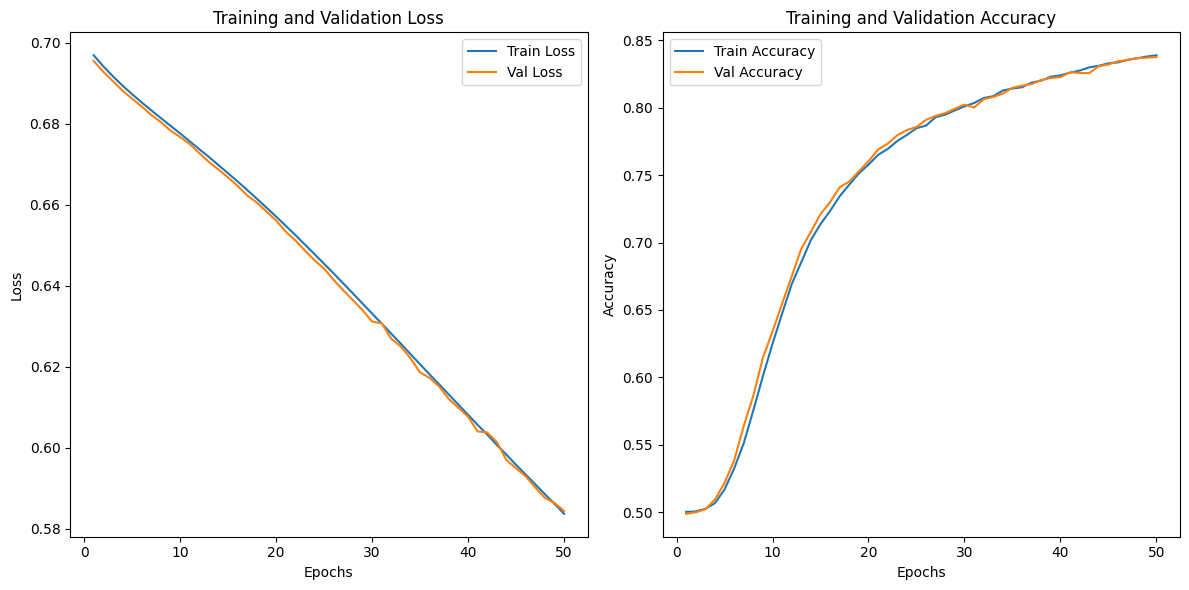

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-9, weight_decay=1e-9)

from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()


train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

# Training loop
epochs = 50
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()


        with autocast():

            outputs = model(images).to(device)
            loss = criterion(outputs, labels)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()


        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    torch.cuda.empty_cache()

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            with autocast():
                outputs = model(images).to(device)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_dpfk_model_CNN_spatial.pth")
        print("Model saved!")


epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
from google.colab import files
files.download('best_dpfk_model_CNN_spatial.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-7-a748e0073f22>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_dpfk_model_CNN_spatial.pth"))
/usr/local/lib/python3.1

Test Accuracy: 81.44%


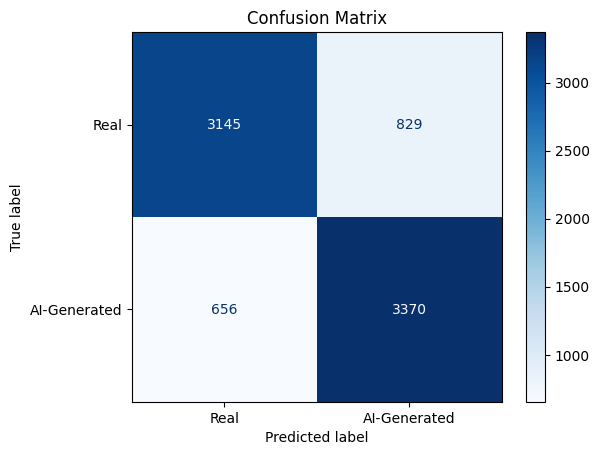

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)
model.load_state_dict(torch.load("best_dpfk_model_CNN_spatial.pth"))
model.eval()

# Test loop
def evaluate_model(model, test_loader, threshold=0.5):
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > threshold
            correct += (predictions.squeeze() == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return np.array(all_preds), np.array(all_labels)


def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "AI-Generated"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

all_preds, all_labels = evaluate_model(model, test_loader)
plot_confusion_matrix(all_labels, all_preds)

In [8]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
def calculate_metrics(all_labels, all_preds):

    binary_preds = (all_preds > 0.5).astype(int)

    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)

    auc = roc_auc_score(all_labels, all_preds)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")

calculate_metrics(all_labels, all_preds)

Precision: 0.8026
Recall: 0.8371
AUC: 0.8142


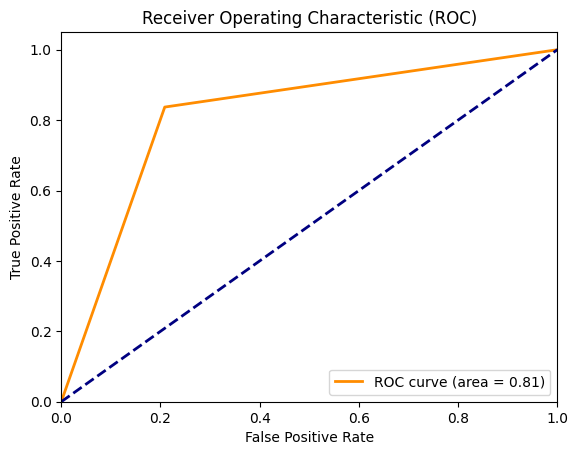

In [9]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(all_labels, all_preds):
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(all_labels, all_preds)

In [13]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
def predict_and_display(model, image, device):

    model.eval()


    preprocess = Compose([
        Resize((256, 256)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        sigmoid_score = torch.sigmoid(output).item()
        prediction = 1 if sigmoid_score > 0.5 else 0

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Sigmoid Score: {sigmoid_score:.4f}\nPrediction: {prediction}")
    plt.show()

<ipython-input-14-88cc58139260>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_dpfk_model_CNN_spatial.pth"))


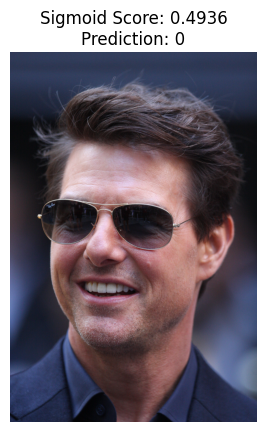

In [14]:
# make sure the model is loaded

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)
model.load_state_dict(torch.load("/content/best_dpfk_model_CNN_spatial.pth"))

from PIL import Image
sample_image = Image.open('/content/Tom_Cruise_(34450932580).jpg')
predict_and_display(model, sample_image, device)

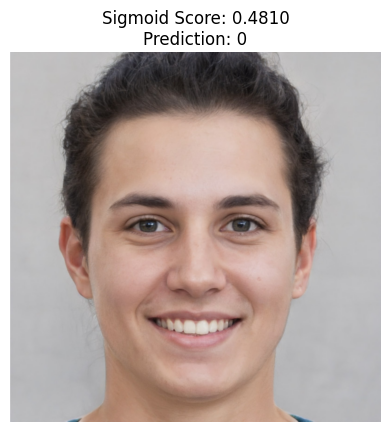

In [15]:
sample_image = Image.open('/content/Screenshot 2024-12-12 at 12.19.18 AM.jpg')
predict_and_display(model, sample_image, device)

But the above image is actually an AI-generated image as shown here: https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html

Look at the other notebook for the model's improved generalization on DCT spectral images.